In [ ]:
!curl https://ollama.ai/install.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13320    0 13320    0     0  28434      0 --:--:-- --:--:-- --:--:-- 28461
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
import os
import asyncio
import threading
import time

os.environ['PATH'] += ':/usr/local/cuda/bin'
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64-nvidia:/usr/local/cuda/lib64'

async def run_process(cmd, stdout=None, stderr=None):
    print('>>> starting', *cmd)
    process = await asyncio.create_subprocess_exec(
        *cmd,
        stdout=stdout or asyncio.subprocess.PIPE,
        stderr=stderr or asyncio.subprocess.PIPE
    )

    if stdout is None and stderr is None:
        async def pipe(lines):
            async for line in lines:
                print(line.decode().strip())

        await asyncio.gather(
            pipe(process.stdout),
            pipe(process.stderr),
        )
    else:
        await process.wait()

async def start_ollama_serve():
    await run_process(['ollama', 'serve'],
                      stdout=open(os.devnull, 'w'),
                      stderr=open(os.devnull, 'w'))

def run_async_in_thread(loop, coro):
    asyncio.set_event_loop(loop)
    loop.run_until_complete(coro)
    loop.close()

new_loop = asyncio.new_event_loop()

thread = threading.Thread(target=run_async_in_thread, args=(new_loop, start_ollama_serve()))
thread.start()

time.sleep(5)

>>> starting ollama serve


In [ ]:
%pip install openai pydantic instructor ipywidgets beautifulsoup4 pandas tqdm chardet matplotlib seaborn wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found existing installation: jiter 0.7.0
    Uninstalling jiter-0.7.0:
      Successfully uninstalled jiter-0.7.0


In [ ]:
import os

OLLAMA_MODEL = "gemma2:9b-instruct-q4_K_M"

!ollama pull {OLLAMA_MODEL}

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling cb654129f57b...   0% ▕▏    0 B/5.8 GB                  pulling manifest 
pulling cb654129f57b...   0% ▕▏    0 B/5.8 GB                  pulling manifest 
pulling cb654129f57b...   0% ▕▏    0 B/5.8 GB                  pulling manifest 
pulling cb654129f57b...   0% ▕▏    0 B/5.8 GB                  pulling manifest 
pulling cb654129f57b...   0% ▕▏    0 B/5.8 GB                  pulling manifest 
pulling cb654129f57b...   0% ▕▏    0 B/5.8 GB                  pulling manifest 
pulling cb654129f57b...   0% ▕▏    0 B/5

In [ ]:
from pydantic import BaseModel, Field
from enum import Enum
from typing import List

class PhishingProbability(str, Enum):
    LOW = "low"
    MEDIUM = "medium"
    HIGH = "high"

class SuspiciousElement(BaseModel):
    element: str
    reason: str

class SimplePhishingAnalysis(BaseModel):
    is_potential_phishing: bool
    phishing_probability: PhishingProbability
    suspicious_elements: List[SuspiciousElement]
    recommended_actions: List[str]
    explanation: str

In [ ]:
from openai import OpenAI
import instructor


def analyze_email(email_content: str) -> SimplePhishingAnalysis:
    client = instructor.from_openai(
      OpenAI(
          base_url="http://127.0.0.1:11434/v1",
          api_key="ollama",
      ),
      mode=instructor.Mode.JSON,
  )

    resp = client.chat.completions.create(
        model=OLLAMA_MODEL,
        messages=[
            {
                "role": "system",
                "content": "You are an advanced AI assistant specialized in cybersecurity, particularly in detecting and analyzing phishing attempts in emails. Your task is to analyze the provided email content and metadata to determine if it's a potential phishing attempt. You must provide your analysis in a structured format that matches the model.",
            },
            {
                "role": "user",
                "content": email_content,
            },
        ],
        response_model=SimplePhishingAnalysis,
    )
    return resp

In [ ]:
import json

# Example phishing email
phishing_email = """
From: security@amazonsupport.net
To: john.doe@company.com
Subject: Urgent: Your Amazon Account Has Been Locked

Dear Valued Customer,

We have detected unusual activity on your Amazon account. To prevent unauthorized access, we have temporarily locked your account for your protection.

To unlock your account and restore full access, please click on the link below and verify your information:

https://amaz0n-account-verify.com/unlock-account

If you do not verify your account within 24 hours, it will be permanently disabled.

Thank you for your prompt attention to this matter.

Best regards,
Amazon Security Team

This email was sent by Amazon.com. To ensure delivery to your inbox, please add security@amazonsupport.net to your address book.
"""

analysis = analyze_email(phishing_email)
print(json.dumps(analysis.model_dump(), indent=2))

# Example legitimate email
legitimate_email = """
From: jennifer.smith@company.com
To: team@company.com
Subject: Quarterly Review Meeting - Thursday, 2 PM

Dear Team,

I hope this email finds you well. I'm writing to remind everyone about our upcoming Quarterly Review Meeting scheduled for this Thursday at 2 PM in the main conference room.

Agenda:
1. Q2 Performance Overview
2. Project Updates
3. Q3 Goals and Strategies
4. Open Discussion

Please come prepared with your team's updates and any questions you may have. If you're unable to attend in person, you can join via our usual video conferencing link:
https://company.zoom.us/j/123456789

Don't forget to bring your laptops for the interactive portion of the meeting.

If you have any questions or need to discuss anything before the meeting, feel free to drop by my office or send me an email.

Looking forward to seeing everyone on Thursday!

Best regards,
Jennifer Smith
Head of Operations
Company Inc.
"""

analysis = analyze_email(legitimate_email)
print(json.dumps(analysis.model_dump()["is_potential_phishing"], indent=2))

{
  "is_potential_phishing": true,
  "phishing_probability": "high",
  "suspicious_elements": [
    {
      "element": "Sender Email Address",
      "reason": "The email address 'security@amazonsupport.net' is not a standard Amazon support address and may be spoofed."
    },
    {
      "element": "Subject Line",
      "reason": "The subject line uses alarming language ('Urgent: Your Amazon Account Has Been Locked') to create a sense of urgency and pressure the recipient to act quickly without thinking."
    },
    {
      "element": "URL in Email",
      "reason": "The provided URL 'https://amaz0n-account-verify.com/unlock-account' is suspicious and likely leads to a fake website designed to steal credentials. Notice the subtle misspelling of 'amazon'."
    },
    {
      "element": "Request for Immediate Action",
      "reason": "The email demands immediate action within 24 hours, creating a false sense of urgency and discouraging careful consideration."
    }
  ],
  "recommended_act

Skipping index 31 due to NaN or non-string value.
Unique values in true labels: {'Safe Email', 'Phishing Email'}
Unique values in predictions: {'Safe Email', 'Phishing Email'}
Classification Report:
                precision    recall  f1-score   support

    Safe Email       0.76      0.94      0.84        17
Phishing Email       0.97      0.85      0.90        33

      accuracy                           0.88        50
     macro avg       0.86      0.89      0.87        50
  weighted avg       0.90      0.88      0.88        50



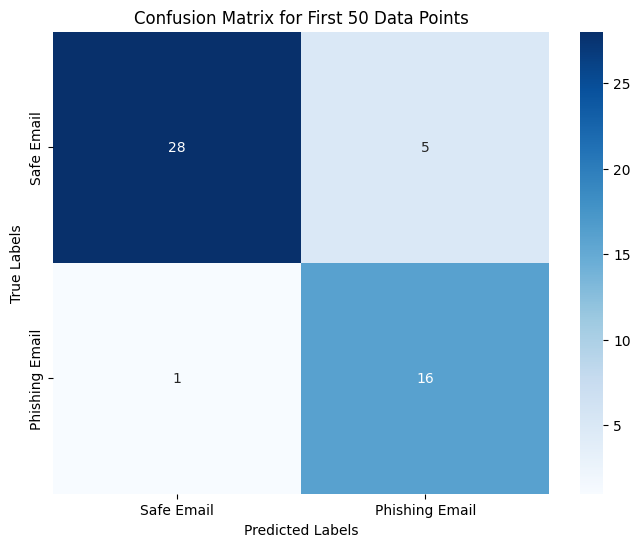

In [ ]:
import json
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Phishing_Email.csv')

# Select the relevant columns
email_texts = df['Email Text']
output = df['Email Type']
total_count = len(email_texts)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

for i in range(total_count):
    # Ensure email_texts[i] is a string (not NaN or None)
    if pd.notna(email_texts[i]) and isinstance(email_texts[i], str):
        analysis = analyze_email(email_texts[i])
        prediction = "Phishing Email" if json.dumps(analysis.model_dump()["is_potential_phishing"]) == "true" else "Safe Email"

        true_labels.append(output[i])
        predictions.append(prediction)

    else:
        print(f"Skipping index {i} due to NaN or non-string value.")

    # Limit the loop to first 50 iterations
    if i == 50:
        break

# Check unique values in true_labels and predictions
print("Unique values in true labels:", set(true_labels))
print("Unique values in predictions:", set(predictions))

# Define the correct valid classes based on dataset
valid_classes = ['Safe Email', 'Phishing Email']

# Filter to include only valid labels in both lists
filtered_true_labels = [label for label in true_labels if label in valid_classes]
filtered_predictions = [pred for pred in predictions if pred in valid_classes]

# Ensure filtered lists have consistent lengths
filtered_true_labels = filtered_true_labels[:len(filtered_predictions)]

# Classification report
print("Classification Report:")
print(classification_report(filtered_true_labels, filtered_predictions, target_names=valid_classes))

# Confusion matrix
conf_matrix = confusion_matrix(filtered_true_labels, filtered_predictions, labels=valid_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=valid_classes, yticklabels=valid_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for First 50 Data Points")
plt.show()


In [ ]:
from IPython.display import display, HTML
import ipywidgets as widgets

# GUI components
email_input = widgets.Textarea(
    value='',
    placeholder='Paste the email content here...',
    description='Email:',
    disabled=False,
    layout={'width': '100%', 'height': '200px'}
)

analyze_button = widgets.Button(
    description='Analyze Email',
    disabled=False,
    button_style='primary',
    tooltip='Click to analyze the email',
    icon='check'
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        print("Analyzing email...")
        try:
            analysis = analyze_email(email_input.value)
            display(HTML(format_analysis(analysis)))
        except Exception as e:
            print(f"An error occurred: {str(e)}")

analyze_button.on_click(on_button_clicked)

def format_analysis(analysis: SimplePhishingAnalysis) -> str:
    color = "red" if analysis.is_potential_phishing else "green"
    result = f"""
    <h2 style="color: {color};">{'Potential Phishing Detected' if analysis.is_potential_phishing else 'Likely Legitimate Email'}</h2>
    <p><strong>Phishing Probability:</strong> {analysis.phishing_probability.value}</p>
    <h3>Suspicious Elements:</h3>
    <ul>
    """
    for element in analysis.suspicious_elements:
        result += f"<li><strong>{element.element}:</strong> {element.reason}</li>"
    result += "</ul>"
    result += f"""
    <h3>Recommended Actions:</h3>
    <ul>
    """
    for action in analysis.recommended_actions:
        result += f"<li>{action}</li>"
    result += "</ul>"
    result += f"<h3>Explanation:</h3><p>{analysis.explanation}</p>"
    return result

# Display the GUI
display(email_input, analyze_button, output)

Textarea(value='', description='Email:', layout=Layout(height='200px', width='100%'), placeholder='Paste the e…

Button(button_style='primary', description='Analyze Email', icon='check', style=ButtonStyle(), tooltip='Click …

Output()